In [84]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split, desc
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import normalize

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.feature_extraction.text import TfidfVectorizer

from nlp_preprocessor import text_preprocessor

#### Create Spark Session

In [85]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

#### Read in reviews data

In [86]:
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [87]:
reviews_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|If you decide to ...|2018-07-07 22:09:11|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|I've taken a lot ...|2012-01-03 15:28:18|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|Family diner. Had...|2014-02-05 20:30:30|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|Wow!  Yummy, diff...|2015-01-04 00:01:03|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|Cu

#### Select only needed columns

In [88]:
reviews_df = reviews_df.select('review_id', 'business_id', 'stars', 'text', 'date')

#### Read in business data

In [89]:
# Read business data
businesses_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)

In [90]:
businesses_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


#### Return business id, given business name
Get 'business_id' with highest review count, given business name. We need 'business_id' to filter reviews using id.

In [91]:
# Get reviews of highest review count business
businesses_found = businesses_df[businesses_df['name'].str.lower() == 'acme oyster house']

# Open businesses found
open_businesses_found = businesses_found[businesses_found.is_open == 1].sort_values('review_count', ascending=False)

business_id = open_businesses_found.iloc[0].business_id

In [92]:
business_id

'_ab50qdWOk0DdB6XOrBitw'

#### Filter reviews given business id
I only need reviews from a single business in downstream processes. Filter reviews df using business_id

In [93]:
# Retrieve reviews for using business id
business_reviews = reviews_df.filter(col('business_id') == business_id)

In [94]:
business_reviews_df = business_reviews.toPandas()

In [95]:
business_reviews_df = business_reviews.toPandas()

In [96]:
# Stop the SparkSession
spark.stop()

#### Text Preprocessing
- Expand Contractions
- *Remove unwanted characters(ignore, not sure about punctuation yet)
- Replace accented characters
- Remove HTML tags
- Collapse whitespace
- Lower case (Standardize the case)

In [97]:
business_reviews_df['text_cleaned'] = business_reviews_df.text.apply(text_preprocessor)

#### Extract year for visualizing review counts trends over years
We want to check what years had highest number of reviews for this business.

In [98]:
# extract year from date
business_reviews_df['year'] = pd.to_datetime(business_reviews_df.date).dt.year

#### Feature Engineering

High-level information:
- Text length(preprocessed text; num of chars)
- Word counts(Count Vectorizer/Tf-Idf/N-grams)
- Average word length

In [99]:
business_reviews_df['char_count'] = business_reviews_df.text_cleaned.str.len()
business_reviews_df['word_count'] = business_reviews_df.text_cleaned.str.split().str.len()
business_reviews_df['avg_word_length'] = business_reviews_df['char_count']/business_reviews_df['word_count']

In [100]:
business_reviews_df.head(2)

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927


#### Content-based features
- Tf-Idf

In [101]:
tv = TfidfVectorizer(
    stop_words="english",
    max_features=8000,
    min_df=0.2,
    max_df=0.9
)

tfidf_matrix = tv.fit_transform(business_reviews_df["text_cleaned"])
tf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tv.get_feature_names_out()).add_prefix('TFIDF_')

In [102]:
tf_df.iloc[0].sort_values(ascending=False)

TFIDF_best           0.582591
TFIDF_wait           0.479278
TFIDF_oysters        0.413473
TFIDF_acme           0.283809
TFIDF_great          0.252700
TFIDF_chargrilled    0.244760
TFIDF_place          0.235814
TFIDF_oyster         0.000000
TFIDF_time           0.000000
TFIDF_service        0.000000
TFIDF_raw            0.000000
TFIDF_po             0.000000
TFIDF_new            0.000000
TFIDF_orleans        0.000000
TFIDF_line           0.000000
TFIDF_just           0.000000
TFIDF_good           0.000000
TFIDF_fried          0.000000
TFIDF_food           0.000000
TFIDF_delicious      0.000000
TFIDF_worth          0.000000
Name: 0, dtype: float64

#### Lemmatize pre-processed reviews (spacy)
We tokenize each review into words, and keep words that carry semantic meaning. We normalize these words into their base form to eliminate redundant meaning and sort of prune our vocabulary.

In [103]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize(preprocessed_text):
    doc = nlp(preprocessed_text)
    return " ".join([t.lemma_ for t in doc if t.is_alpha and not t.is_stop])

In [104]:
business_reviews_df["lemmas"] = business_reviews_df["text_cleaned"].apply(lemmatize)

#### Business reviews yearly count

In [105]:
business_reviews_per_year = business_reviews_df.year.value_counts().sort_index()
business_reviews_per_year = business_reviews_per_year.reset_index()
business_reviews_per_year.columns = ['year', 'num_reviews']
business_reviews_per_year

,year,num_reviews
0,2006,9
1,2007,15
2,2008,59
3,2009,173
4,2010,240
5,2011,347
6,2012,367
7,2013,535
8,2014,631
9,2015,802


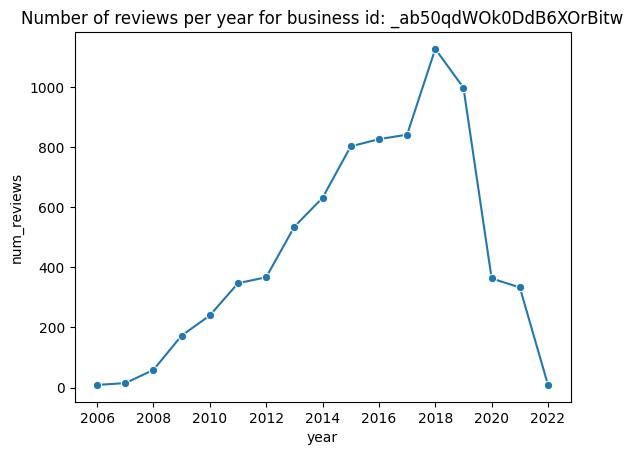

In [106]:
sns.lineplot(x='year', y='num_reviews', marker='o', data=business_reviews_per_year)
plt.title(f"Number of reviews per year for business id: {business_id}")
plt.show()

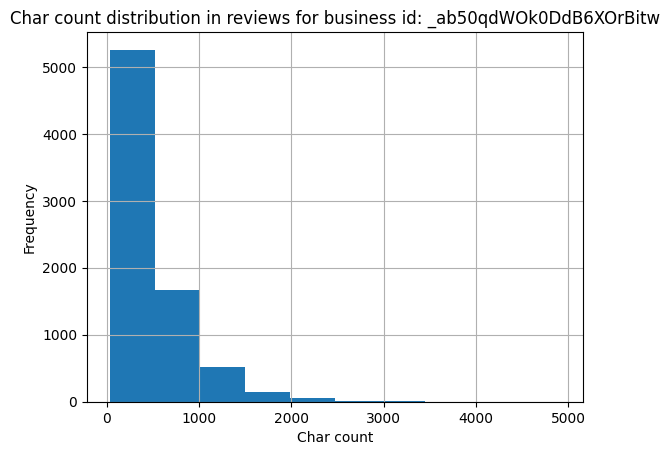

In [107]:
business_reviews_df.hist('char_count')
plt.title(f"Char count distribution in reviews for business id: {business_id}")
plt.xlabel('Char count')
plt.ylabel('Frequency')
plt.show()

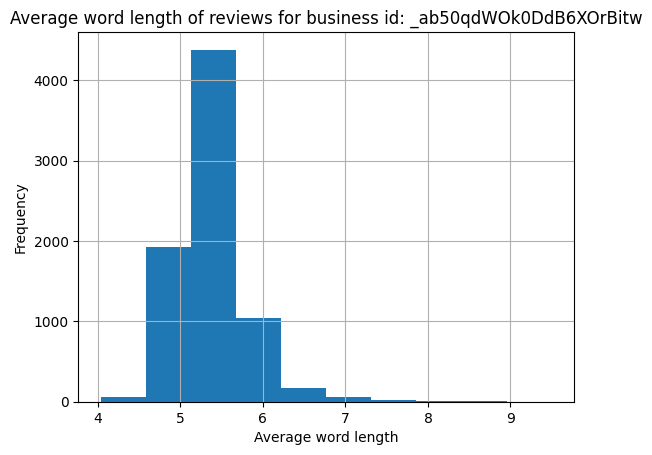

In [108]:
business_reviews_df.hist('avg_word_length')
plt.title(f"Average word length of reviews for business id: {business_id}")
plt.xlabel('Average word length')
plt.ylabel('Frequency')
plt.show()

#### Do 1-star rated reviews tend to be longer or shorter?
This is based on cleaned review text not original text.

In [117]:
business_reviews_df.head()

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas,normalized_embeddings
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...,"[0.041993144899606705, 0.05851171910762787, 0...."
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...,"[-0.03591486066579819, -0.03511025756597519, 0..."
2,469eAl2fB069YTF_B5zW7w,_ab50qdWOk0DdB6XOrBitw,5.0,The fried seafood was extremely hot. Very nice...,2018-08-23 20:58:39,the fried seafood was extremely hot. very nice...,2018,530,97,5.463918,fried seafood extremely hot nice taste add sof...,"[-0.03977707028388977, 0.028981056064367294, 0..."
3,aPpHBDs7Jiiq0sb9YutOhQ,_ab50qdWOk0DdB6XOrBitw,5.0,I love this place. I wish my stay was longer s...,2013-06-24 18:07:12,i love this place. i wish my stay was longer s...,2013,193,40,4.825000,love place wish stay long visit food awesome d...,"[-0.023319782689213753, 0.018473681062459946, ..."
4,k9OG5kA5ebruSx_f1T-P-A,_ab50qdWOk0DdB6XOrBitw,3.0,"Loved the chargrilled oysters! I mean, seriou...",2010-10-06 08:03:20,"loved the chargrilled oysters! i mean, serious...",2010,1277,230,5.552174,love chargrilled oyster mean seriously tasty c...,"[-0.018412481993436813, 0.05632537975907326, 0..."


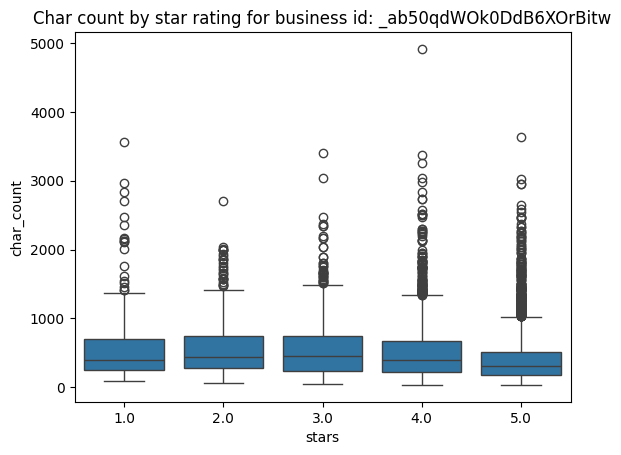

In [110]:
sns.boxplot(x='stars', y='char_count', data=business_reviews_df)
plt.title(f"Char count by star rating for business id: {business_id}")
plt.show()

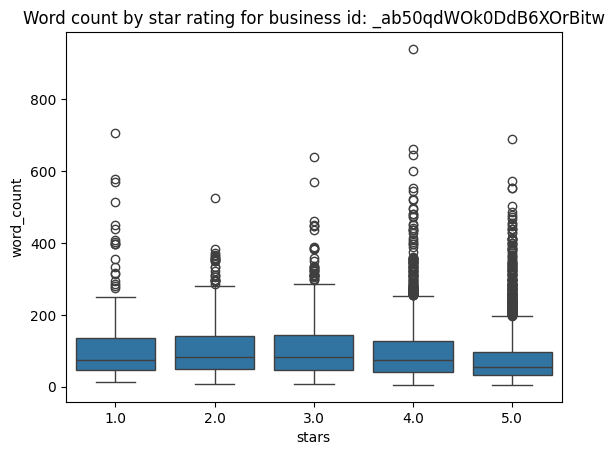

In [111]:
sns.boxplot(x='stars', y='word_count', data=business_reviews_df)
plt.title(f"Word count by star rating for business id: {business_id}")
plt.show()

Star rating does not corrspond strongly to review text length or word count

### Embeddings
I have evaluated different embedding models(static and contextual), but I will using 'paraphrase-MiniLM-L3-v2'

In [112]:
my_mpnet_transformer = MySentenceTransformer(model_name='paraphrase-MiniLM-L3-v2')

In [113]:
embs = my_mpnet_transformer.transform_sentences(business_reviews_df.text_cleaned)

Since we are interested in clustering aka grouping similar reviews together for theme extraction, we need to normalize/scale embeddings magnitude to 1. 

In [114]:
normalized_embs = normalize(embs)

In [115]:
business_reviews_df['normalized_embeddings'] = normalized_embs.tolist()

In [116]:
business_reviews_df.head(2)

,review_id,business_id,stars,text,date,text_cleaned,year,char_count,word_count,avg_word_length,lemmas,normalized_embeddings
0,vHLTOsdILT7xgTu7TAWTUQ,_ab50qdWOk0DdB6XOrBitw,5.0,This place has amazing oysters and the BEST bl...,2016-07-25 04:34:34,this place has amazing oysters and the best bl...,2016,557,107,5.205607,place amazing oyster well bloody mary stay nol...,"[0.041993144899606705, 0.05851171910762787, 0...."
1,I90lP6oPICTkrhCFGQt5tA,_ab50qdWOk0DdB6XOrBitw,5.0,OH MY!! A must try. We had no idea there would...,2016-12-19 20:27:16,oh my!! a must try. we had no idea there would...,2016,425,82,5.182927,oh try idea line definitely worth oyster amazi...,"[-0.03591486066579819, -0.03511025756597519, 0..."


# Save data

In [122]:
tf_df

,TFIDF_acme,TFIDF_best,TFIDF_chargrilled,TFIDF_delicious,TFIDF_food,TFIDF_fried,TFIDF_good,TFIDF_great,TFIDF_just,TFIDF_line,...,TFIDF_orleans,TFIDF_oyster,TFIDF_oysters,TFIDF_place,TFIDF_po,TFIDF_raw,TFIDF_service,TFIDF_time,TFIDF_wait,TFIDF_worth
0,0.283809,0.582591,0.244760,0.000000,0.000000,0.000000,0.000000,0.252700,0.000000,0.000000,...,0.000000,0.000000,0.413473,0.235814,0.000000,0.000000,0.000000,0.000000,0.479278,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.574414,...,0.000000,0.000000,0.348148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.740839
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.258081,0.186617,0.444631,0.000000,0.400112,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.479627,0.000000,0.210825,0.516036
3,0.000000,0.000000,0.000000,0.000000,0.451968,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.548417,0.000000,0.000000,0.453874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.164636,0.000000,0.425952,0.172112,0.000000,0.510519,0.123051,0.000000,0.161904,0.000000,...,0.000000,0.297617,0.559658,0.000000,0.170464,0.170298,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7668,0.000000,0.000000,0.000000,0.000000,0.204096,0.254967,0.737462,0.000000,0.242578,0.395284,...,0.000000,0.000000,0.119789,0.000000,0.000000,0.000000,0.236920,0.252812,0.000000,0.000000
7669,0.000000,0.000000,0.000000,0.000000,0.268927,0.000000,0.000000,0.000000,0.000000,0.520846,...,0.000000,0.000000,0.000000,0.810183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7670,0.000000,0.000000,0.000000,0.273254,0.000000,0.000000,0.586087,0.000000,0.257047,0.000000,...,0.000000,0.000000,0.253869,0.217182,0.000000,0.540746,0.251051,0.000000,0.220704,0.000000
7671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250037,0.000000,0.000000,0.268043,...,0.000000,0.000000,0.487377,0.555926,0.000000,0.346041,0.000000,0.000000,0.282472,0.345703


In [124]:
path = f'filtered/business_reviews_{business_id}.parquet'
tfidf_path = f'filtered/tfidf_{business_id}.parquet'

# remove folder if it exists (from previous PySpark save)
if os.path.isdir(path):
    shutil.rmtree(path)

# now safely save as a single parquet file
business_reviews_df.to_parquet(path, index=False)
tf_df.to_parquet(tfidf_path, index=False)